In [17]:
###### Part1. Shapoo Sales Dataset 
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

# from pandas import read_csv
# from pandas import datetime
# import matplotlib.pyplot as plt
# # load dataset
# def parser(x):
# 	return datetime.strptime('190'+x, '%Y-%m')
# series = read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# # summarize first few rows
# print(series.head())
# # line plot
# plt.figure(figsize=(10, 5))
# plt.plot(series)
# plt.grid()
# plt.show()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


In [5]:
# Experimental Test Harness,
# Part 2: Run an experiment with a stateful LSTM on the network twice.
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		# model.reset_states() #1 Reset state after each training epoch
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	# model.reset_states() #2 Reset after each one-step prediction (update after each test) 
	return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values[1:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 1000, 1)
		#3 seed the state of LSTM after training with the state from making predictions on the training dataset
		# forecast train dataset
		for i in range(len(train_scaled)):
			X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
		# forecast test dataset
		predictions = list()
		for i in range(len(test_scaled)):
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# execute the experiment
def run():
	# load dataset
	series = read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# experiment
	repeats = 10
	results = DataFrame()
	# run experiment
	results['results'] = experiment(repeats, series)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_stateful_seed_train_no_resets.csv', index=False)

 # entry point
run()


1) Test RMSE: 103.273
2) Test RMSE: 101.905
3) Test RMSE: 90.969
4) Test RMSE: 89.548
5) Test RMSE: 99.700
6) Test RMSE: 101.899
7) Test RMSE: 92.187
8) Test RMSE: 103.536
9) Test RMSE: 93.562
10) Test RMSE: 109.270
          results
count   10.000000
mean    98.585043
std      6.580745
min     89.547818
25%     92.530814
50%    100.799533
75%    102.931201
max    109.270241


stateful   stateful2
count   10.000000   10.000000
mean   102.512061   99.956375
std      9.744082    5.182922
min     90.779743   91.630593
25%     97.691668   95.908057
50%    101.723799  101.638964
75%    104.152803  102.632718
max    126.477705  107.421938


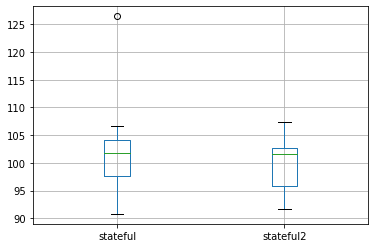

In [68]:
# Part 3: Now load and compare 2 files 
import pandas as pd
from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
# load results into a dataframe
filenames = ['experiment_stateful.csv', 'experiment_stateful2.csv']
results = DataFrame()
for name in filenames:
	df = read_csv(name, header=0)
	# print(name[11:-4]) 
	# retrieves the strings “stateful” and “stateful2” from the respective filenames
	results[[name[11:-4]]] = df 
	
# describe all results
print(results.describe())
# box and whisker plot
pyplot.figure(figsize=(6, 4))
results.boxplot()
pyplot.show()

# import matplotlib.pyplot as plt
# import pandas as pd
# data = DataFrame()
# for file in filenames:
#     df = pd.read_csv(file, header = 0)
#     df['file'] = file
#     data = pd.concat([data, df])

# # LABELS = ["Stateful 1", "Stateful 2"]
# data.boxplot(by='file')
# plt.show()



stateful  stateless  stateless_shuffle
count   10.000000  10.000000          10.000000
mean   102.512061  95.178655          94.927373
std      9.744082   0.824906           0.986771
min     90.779743  93.340561          93.468168
25%     97.691668  94.900169          94.406821
50%    101.723799  95.219478          94.874823
75%    104.152803  95.666620          95.548467
max    126.477705  96.261360          96.328004


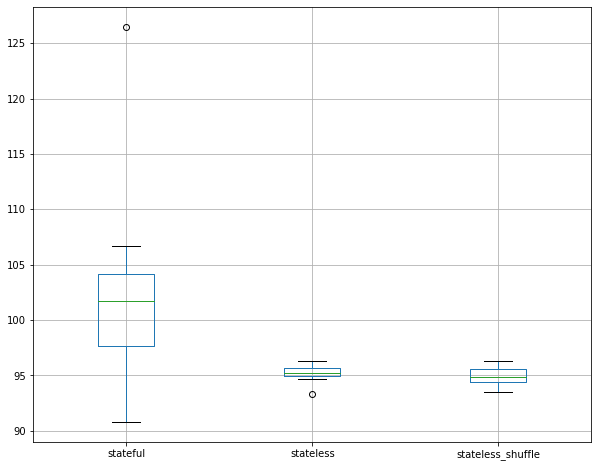

In [76]:
# Part4: Stateful vs Stateless LSTMs
# In this section, we will contrast:

# A Stateful LSTM (first result from the previous section).
# A Stateless LSTM with the same configuration.
# A Stateless LSTM with shuffling during training.
from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
# load results into a dataframe
filenames = ['experiment_stateful.csv', 'experiment_stateless.csv',
	'experiment_stateless_shuffle.csv']
results = DataFrame()
for name in filenames:
	results[[name[11:-4]]] = read_csv(name, header=0)
# describe all results
print(results.describe())
# box and whisker plot
pyplot.figure(figsize=(10, 8))
results.boxplot()
pyplot.show()


stateful_batch12  stateless_batch12
count         10.000000          10.000000
mean         105.376146         105.553117
std           10.408710          12.491622
min           97.446936          92.262317
25%           97.923594          95.477033
50%           99.485348         102.684525
75%          110.669160         109.706175
max          124.771875         127.390868


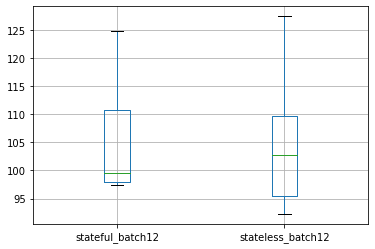

In [5]:
"""We will use the stateless LSTM configuration from the previous experiment with training pattern shuffling turned off as the starting point. The experiment uses the same forecast_lstm() and experiment() functions listed above. Results are written to the file “experiment_stateless_batch12.csv“.

After running this experiment, you will have two result files:"""
"""stateful=True""" # experiment_stateful_batch12.csv 
"""stateful=False""" # experiment_stateless_batch12.csv
# Change cod the following lines then run 
#train, test = supervised_values[-24:-12, :], supervised_values[-12:, :]
# model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
# model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)

from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
# load results into a dataframe
filenames = ['experiment_stateful_batch12.csv', 'experiment_stateless_batch12.csv']
results = DataFrame()
for name in filenames:
	results[[name[11:-4]]] = read_csv(name, header=0)
# describe all results
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()


noseed_1    noseed_2    noseed_3      seed_1      seed_2      seed_3
count   10.000000   10.000000   10.000000   10.000000   10.000000   10.000000
mean   102.512061   94.280976  105.814261  103.449642  104.070619   98.585043
std      9.744082    3.477787   16.690625    7.435907   20.919853    6.580745
min     90.779743   90.984787   89.682186   99.801325   90.603767   89.547818
25%     97.691668   91.939649   98.670648  100.269353   92.398456   92.530814
50%    101.723799   92.676946  100.008488  101.365558   95.267911  100.799533
75%    104.152803   95.905725  103.021270  102.177200   99.347565  102.931201
max    126.477705  100.267321  144.863232  124.406378  153.012367  109.270241


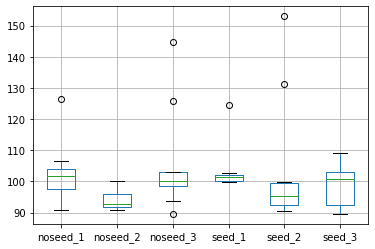

In [7]:
from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
# load results into a dataframe
filenames = ['experiment_stateful.csv', 'experiment_stateful_reset_test.csv',
	'experiment_stateful_noreset.csv', 'experiment_stateful_seed_train.csv',
	'experiment_stateful_seed_train_resets.csv', 'experiment_stateful_seed_train_no_resets.csv']
results = DataFrame()
for name in filenames:
	results[[name]] = read_csv(name, header=0)
results.columns = ['noseed_1', 'noseed_2', 'noseed_3', 'seed_1', 'seed_2', 'seed_3']
# describe all results
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()


